In [29]:
import yaml
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import metrics
import pandas as pd
import numpy as np

In [30]:
import os,sys
root_path = os.path.dirname(os.path.dirname(os.path.abspath('run.py')))
sys.path.append(root_path)
from cfg import cfg
from numerapi.numerapi import NumerAPI
import models
from data_utils import data_files
from data_utils import get_data_era_balanced,data_files,get_data, write_to_csv


In [3]:
kwargs = cfg['api']

In [5]:
import os,sys
root_path = os.path.dirname(os.path.dirname(os.path.abspath('run.py')))
sys.path.append(root_path)

from cfg import cfg
from numerapi.numerapi import NumerAPI
import models
from data_utils import get_data_era_balanced,data_files,get_data, write_to_csv
import imp
from models import opt

model_list = [
    ('aecgan',models.aec_gan.AecAdvModel,dict(istrain=False)),
    ('aec',models.aec.AecModel,dict(istrain=False)),
    ('xg',models.xg.XgModel,dict(istrain=False)),
    ('aecganxg',models.aec_gan_xg.AecGanXgModel,dict(istrain=False)),# depends on model from AecAdvModel
    ('aecgs',models.aec_gan_stack.AecAdvStackModel,dict(istrain=False)),
    ('ganmore',models.ganmore.GanMoreModel,dict(istrain=False)),
    ('simplekfold',models.simplekfold.SimpleKfold,dict(istrain=False)),
    ('disentangle_kfold',models.disentangle_kfold.DisentangleKfoldModel,dict(istrain=False)),
]

In [6]:
X_test,y_test,ids,_eras,_datatypes=get_data(data_files[-1]['testpath'])
X_train,y_train,X_val,y_val = get_data_era_balanced(data_files[-1]['trainpath'])

<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'>
(314837, 50) (314837,) (78776, 50) (78776,)


In [31]:
import imp
imp.reload(models)
model_list = [
     ('aecgan',models.aec_gan.AecAdvModel,dict(istrain=False)),
     ('aec',models.aec.AecModel,dict(istrain=False)),
     #('xg',models.xg.XgModel,dict(istrain=False)),
     #('aecganxg',models.aec_gan_xg.AecGanXgModel,dict(istrain=False)),# depends on model from AecAdvModel
     #('aecgs',models.aec_gan_stack.AecAdvStackModel,dict(istrain=False)), # depends on model from AecAdvModel
#    ('ganmore',models.ganmore.GanMoreModel,dict(istrain=False)),
     ('disentangle',models.disentangle.DisentangleModel,dict(istrain=False)),
     ('disentangle_kfold',models.disentangle_kfold.DisentangleKfoldModel,dict(istrain=False)),
     ('disentanglegan',models.disentanglegan.DisentangleGanModel,dict(istrain=False)),
     #('idg',models.icadisengan.IcaDisentangleGanModel,dict(istrain=False)),
     #('mdg',models.moddisengan.DisentangleModel,dict(istrain=True)),
    ('tsnesimple',models.tsne_simple.TsneSimple,dict(istrain=False)),
    ('tsnesimplekfold',models.tsne_simplekfold.TsneSimpleKfold,dict(istrain=False)),
    ('simple',models.simple.Simple,dict(istrain=False)),
    ('simplekfold',models.simplekfold.SimpleKfold,dict(istrain=False)),
]

In [23]:
val_inds = np.array(np.where(_datatypes=='validation')).squeeze()

In [24]:
val_inds.shape

(46362,)

In [32]:

def to_int(e):
    try:
        return int(e.strip('era'))
    except:
        return float('nan')
ll_list = [{},{}]
raw = {}


for n,p in enumerate(['trainpath','testpath']):
    X__,y__,ids__,eras__,datatypes__=get_data(data_files[-1][p])
    index_dict={}
    X_train_tr,y_train_tr,X_val_tr,y_val_tr = get_data_era_balanced(
        data_files[-1][p],index_dict=index_dict)
    X__ = X_val_tr
    y__ = y_val_tr
    
    eras__ = eras__[index_dict['validation']]
    
    val_eras = sorted([x for x in np.unique(eras__) if x not in ['eraX']])
    raw[p]={'y_true':y__,'m':{},'eras':eras__,'val_eras':val_eras}
    ll={}
    for name,clsf,params in model_list:
        inst = clsf()
        inst.load()
        y_pred,_ = inst.predict(X__)
        raw[p]['m'][name]={'y_pred':y_pred}
        ll[name]=[]
        for era in val_eras:
            inds = np.array(np.where(eras__==era)).squeeze()            
            l = opt.log_loss_func([1.],[y_pred[inds]],y__[inds])
            ll[name].append({'eras':to_int(era),'log_loss':l,'stds':np.nanstd(y_pred[inds].squeeze()-y__[inds])})
        ll[name] = pd.DataFrame(ll[name])
    ll_list[n].update(ll)
    for k in sorted(ll.keys()):
        v = ll[k].log_loss
        consistency = np.sum(v<-np.log(0.5))/len(v)
        mila = np.mean(v)
        print('{} {} cons:{:1.4f} logloss:{:1.4f}'.format(p,k,consistency,mila))
# https://github.com/numerai/submission-criteria/blob/daac1970a984cd4392c720771d3c5c4bcb9de1d4/submission_criteria/database_manager.py#L71 

<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'>
(314837, 50) (314837,) (78776, 50) (78776,)


/home/yoyoteng/anaconda3/envs/py35/lib/python3.5/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.
  return getattr(obj, method)(*args, **kwds)


(78776, 1)
[  4.85879925e-01   2.77555756e-17   9.37365615e-03   7.97782664e-02
   4.24968152e-01] (5, 78776) (78776,)
0
1
2
3
4
trainpath aec cons:0.6083 logloss:0.6926
trainpath aecgan cons:0.6000 logloss:0.6926
trainpath disentangle cons:0.6000 logloss:0.6931
trainpath disentangle_kfold cons:0.5000 logloss:0.6931
trainpath disentanglegan cons:0.5333 logloss:0.6931
trainpath simple cons:0.6333 logloss:0.6922
trainpath simplekfold cons:0.7417 logloss:0.6916
trainpath tsnesimple cons:0.6667 logloss:0.6924
trainpath tsnesimplekfold cons:0.6333 logloss:0.6923
<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'>
(37084, 50) (37084,) (9278, 50) (9278,)
(9278, 1)
[  4.85879925e-01   2.77555756e-17   9.37365615e-03   7.97782664e-02
   4.24968152e-01] (5, 9278) (9278,)
0
1
2
3
4
testpath aec cons:0.8333 logloss:0.6922
testpath aecgan cons:0.6667 logloss:0.6922
testpath disentangle cons:0.6667 logloss:

In [33]:


print('ok')
name = 'opt'
for n,p in enumerate(['trainpath','testpath']):
    y_true = raw[p]['y_true']
    pred_list = []
    for k,v in raw[p]['m'].items():
        pred_list.append(v['y_pred'].squeeze())
    
    if p =='trainpath':
        w = opt.opt_weights(pred_list,y_true)
    
    pred_list = np.array(pred_list)
    # calculate pred
    y_pred = np.dot(w,pred_list)
    print(y_pred.shape)
    #raw[p]={'y_true':y__,'m':{},'eras':eras__,'val_eras':val_eras}
    val_eras = raw[p]['val_eras']
    eras__ = raw[p]['eras']
    y__ = raw[p]['y_true']
    print(y__.shape)
    ll={name:[]}
    for era in val_eras:
        inds = np.array(np.where(eras__==era)).squeeze()
        l = opt.log_loss_func([1.],[y_pred[inds]],y__[inds])
        ll[name].append({'eras':to_int(era),'log_loss':l,'stds':np.nanstd(y_pred[inds].squeeze()-y__[inds])})
    ll[name] = pd.DataFrame(ll[name])
    
    ll_list[n].update(ll)


ok
!! (9, 78776) (78776,)
Ensemble Score: 0.24957010590134887
Best Weights: [  1.19961751e-01   2.70927971e-01   2.41172471e-01   5.55111512e-17
   1.11022302e-16   0.00000000e+00   3.67937807e-01   0.00000000e+00
   0.00000000e+00]
Ensemble Score: 0.24946145996287547
Best Weights: [  0.00000000e+00   1.68126937e-01   5.90787515e-02   4.66498972e-01
   8.90115432e-02   2.77555756e-17   5.55111512e-17   1.19963164e-02
   2.05287480e-01]
Ensemble Score: 0.24958704951362232
Best Weights: [  0.00000000e+00   5.55111512e-17   2.89013162e-01   0.00000000e+00
   1.11022302e-16   0.00000000e+00   0.00000000e+00   4.76486103e-01
   2.34500736e-01]
Ensemble Score: 0.2493718108066085
Best Weights: [  0.00000000e+00   5.35582765e-02   0.00000000e+00   5.55111512e-17
   2.33174431e-01   4.35855585e-01   0.00000000e+00   5.55111512e-17
   2.77411707e-01]
Ensemble Score: 0.2496624809084891
Best Weights: [  3.13013364e-01   2.22773249e-01   1.11022302e-16   0.00000000e+00
   1.66533454e-16   0.0000000

In [ ]:
print('\n'.join(['{} {:1.4f}'.format(m[0],w0) for m,w0 in zip(model_list,w)]))

aecgan 0.0000
aec 0.2918
disentangle 0.0495
disentangle_kfold 0.0000
disentanglegan 0.0000
tsnesimple 0.3104
tsnesimplekfold 0.0000
simple 0.0000
simplekfold 0.3482


aec
0.49936 0.6083 73 120
0.49903 0.8333 10 12
--
aecgan
0.49938 0.6000 72 120
0.49905 0.6667 8 12
--
disentangle
0.49961 0.6000 72 120
0.49945 0.6667 8 12
--
disentangle_kfold
0.49962 0.5000 60 120
0.49951 0.5833 7 12
--
disentanglegan
0.49960 0.5333 64 120
0.49942 0.6667 8 12
--
opt
0.49889 0.7750 93 120
0.49850 0.9167 11 12
--
simple
0.49912 0.6333 76 120
0.49866 0.8333 10 12
--
simplekfold
0.49884 0.7417 89 120
0.49849 0.8333 10 12
--
tsnesimple
0.49926 0.6667 80 120
0.49888 0.6667 8 12
--
tsnesimplekfold
0.49922 0.6333 76 120
0.49892 0.8333 10 12
--


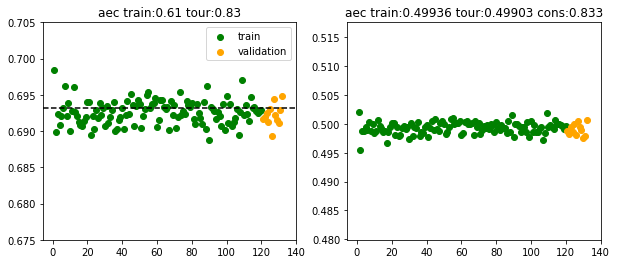

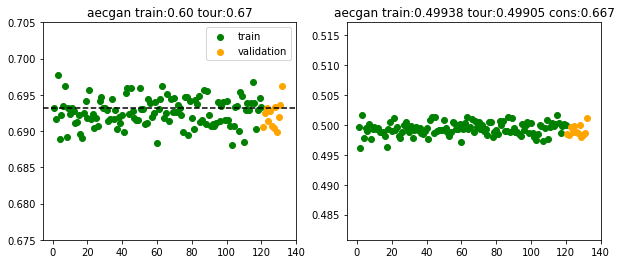

In [ ]:
m_list = ['disentangle']#,'aecgan'
m_list = list(sorted(ll_list[0].keys()))

for n,mn in enumerate(m_list):
    tr_dn=np.sum(ll_list[0][mn].log_loss < -np.log(0.5))
    tr_nu=ll_list[0][mn].log_loss.shape[0]
    tr_cons=tr_dn/float(tr_nu)
    tr_std=ll_list[0][mn].stds.mean()
    print(mn)
    print('{:1.5f} {:1.4f} {} {}'.format(tr_std,tr_cons,tr_dn,tr_nu))
    tor_dn=np.sum(ll_list[1][mn].log_loss < -np.log(0.5))
    tor_nu=ll_list[1][mn].log_loss.shape[0]
    tor_std=ll_list[1][mn].stds.mean()
    tor_cons=tor_dn/float(tor_nu)
    print('{:1.5f} {:1.4f} {} {}'.format(tor_std,tor_cons,tor_dn,tor_nu))
    print('--')
    plt.figure(n,figsize=(10,4))
    plt.subplot(121)
    plt.title('{} train:{:1.2f} tour:{:1.2f}'.format(mn,tr_cons,tor_cons))
    plt.scatter(ll_list[0][mn].eras,ll_list[0][mn].log_loss,label='train',color='green')
    plt.scatter(ll_list[1][mn].eras,ll_list[1][mn].log_loss,label='validation',color='orange')
    plt.ylim(0.675,0.705)
    plt.legend()
    plt.axhline(y=-np.log(0.5), xmin=0, xmax=1,color='k',linestyle='--')
    plt.subplot(122)
    plt.title('{} train:{:1.5f} tour:{:1.5f} cons:{:1.3f}'.format(mn,tr_std,tor_std,tor_cons))
    plt.scatter(ll_list[0][mn].eras,ll_list[0][mn].stds,label='train',color='green')
    plt.scatter(ll_list[1][mn].eras,ll_list[1][mn].stds,label='validation',color='orange')


In [ ]:
aec=models.aec.AecModel()
aec.load()
adv=models.aec_gan.AecAdvModel()
adv.load()
adx=models.aec_gan_xg.AecGanXgModel()
adx.load()

In [ ]:
for x in [X_train,X_val,X_test]:
    aecdX = aec.decoder.predict(x)
    advdX = adv.decoder.predict(x)
    adxdX = adx.aa_inst.decoder.predict(x)
    print('---------')
    print('aec',metrics.mean_squared_error(aecdX,x))
    print('adv',metrics.mean_squared_error(advdX,x))
    print('adx',metrics.mean_squared_error(adxdX,x))

In [ ]:
mn = 'aecganxg'
plt.figure(0)
plt.scatter(ll_list[0][mn].eras,ll_list[0][mn].log_loss,label='train',color='green')
plt.scatter(ll_list[1][mn].eras,ll_list[1][mn].log_loss,label='validation',color='orange')
plt.legend()
plt.axhline(y=-np.log(0.5), xmin=0, xmax=1,color='k',linestyle='--')
plt.figure(1)
plt.scatter(ll_list[1][mn].eras,ll_list[1][mn].log_loss,label='validation',color='orange')
plt.legend()
plt.axhline(y=-np.log(0.5), xmin=0, xmax=1,color='k',linestyle='--')

In [ ]:
import numpy as np
import pandas as pd
from sklearn.decomposition import FastICA
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, make_union
from tpot.builtins import StackingEstimator

#X_test,y_test,ids,_eras,_datatypes=get_data(data_files[-1]['testpath'])
#X_train,y_train,X_val,y_val = get_data_era_balanced(data_files[-1]['trainpath'])

# Score on the training set was:0.6049871246781169
# exported_pipeline = make_pipeline(
#     FastICA(tol=0.35000000000000003),
#     StackingEstimator(estimator=ExtraTreesClassifier(bootstrap=False, criterion="gini", max_features=0.1, min_samples_leaf=3, min_samples_split=14, n_estimators=100)),
#     ExtraTreesClassifier(bootstrap=False, criterion="entropy", max_features=0.6500000000000001, min_samples_leaf=17, min_samples_split=13, n_estimators=100)
# )
args = [
    FastICA(tol=0.35000000000000003),
    StackingEstimator(estimator=ExtraTreesClassifier(bootstrap=False, criterion="gini", max_features=0.1, min_samples_leaf=3, min_samples_split=7, n_estimators=100)),
    ExtraTreesClassifier(bootstrap=False, criterion="entropy", max_features=0.6500000000000001, min_samples_leaf=, min_samples_split=6, n_estimators=80),

]
exported_pipeline = make_pipeline(
    *args,
    memory=memory
)

exported_pipeline.fit(X_train, y_train)
results = exported_pipeline.predict(X_test)


import pickle
with open('mymodel','wb') as f:
    pickle.dump(model,f)

In [ ]:
for p in ['trainpath','testpath']:
    X__,y__,ids__,eras__,datatypes__=get_data(data_files[-1][p])
    results = exported_pipeline.predict_proba(X__)
    val_eras = [x for x in np.unique(eras__) if x not in ['eraX']]
    ll = {}
    name = 'tpot'
    ll[name]=[]
    for era in val_eras:
        inds = np.array(np.where(eras__==era)).squeeze()
        l = opt.log_loss_func([1.],[results[inds]],y__[inds])
        ll[name].append({'eras':to_int(era),'log_loss':l})
    ll[name] = pd.DataFrame(ll[name])
    ll_list.append(ll)
    for k in sorted(ll.keys()):
        v = ll[k].log_loss
        consistency = np.sum(v<-np.log(0.5))/len(v)
        mila = np.mean(v)
        print('{} {} cons:{:1.4f} logloss:{:1.4f}'.format(p,k,consistency,mila))


In [ ]:
opt_weights = opt.opt_weights(y_pred_list,y_test[val_inds])

In [ ]:
opt_pred = opt.opt_pred(y_pred_list,opt_weights)
print(len(y_pred_list),opt_weights.shape,opt_pred.shape)
print('final logloss',name,opt.log_loss_func([1.0],[opt_pred],y_test[val_inds]))

In [ ]:
print(['{:.8f}'.format(x) for x in opt_weights])
print(np.sum(opt_weights))